In [278]:
# import from kaggel dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [279]:
#import the data from a github repository

url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'
data = pd.read_csv(url)

# create a dataframe
df = pd.DataFrame(data)

### Data prep

In [280]:
# check the first 5 rows
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [281]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [282]:
df.head().T

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


In [283]:
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

there are some column with extrange types. Like for example totalcharges that is object. 

If I look into totalcharges and try to convert into number... will fail as there are some missing values, but we can say if there is an error they can ommit it.

In [284]:
tc = pd.to_numeric(df.totalcharges, errors='coerce')


In [285]:
df[tc.isnull()][['customerid', 'totalcharges']]


,customerid,totalcharges
488,4472-lvygi,_
753,3115-czmzd,_
936,5709-lvoeq,_
1082,4367-nuyao,_
1340,1371-dwpaz,_
3331,7644-omvmy,_
3826,3213-vvolg,_
4380,2520-sgtta,_
5218,2923-arzlg,_
6670,4075-wkniu,_


In [286]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

In [287]:
df.totalcharges = df.totalcharges.fillna(0)

Checking churn column and chaging to integer (1 or 0)

In [288]:
df.churn = (df.churn == 'yes').astype(int)

In [289]:
df.churn.value_counts()

churn
0    5174
1    1869
Name: count, dtype: int64

In [290]:
df.churn.value_counts(normalize=True)

churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

### Setting up our validation framework

In [291]:
# to make the split we will use the train test split function from sklearn instead of the one from pandas
from sklearn.model_selection import train_test_split

train_test_split?

Signature:
train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
)
Docstring:
Split arrays or matrices into random train and test subsets.

Quick utility that wraps input validation,
``next(ShuffleSplit().split(X, y))``, and application to input data
into a single call for splitting (and optionally subsampling) data into a
one-liner.

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
*arrays : sequence of indexables with same length / shape[0]
    Allowed inputs are lists, numpy arrays, scipy-sparse
    matrices or pandas dataframes.

test_size : float or int, default=None
    If float, should be between 0.0 and 1.0 and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. If None, the value is set to the
    complement of the train size. If ``train_size`` is also None, it will
    be set to 0.25.

trai

In [292]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [293]:
len(df_full_train), len(df_test)

(5634, 1409)

In [294]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [295]:
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

In [296]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [297]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values


In [298]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

not deleted the churn variable in the full dataset

### Exploratory data analysis

In [299]:
# missing values
df_full_train.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

no aditional change, no missing variables.


In [300]:
# Distribution of the target variable
df_full_train.churn.value_counts(normalize=True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

26% of users churning vs 73% staying

In [301]:
global_churn_rate = df_full_train.churn.mean()
round(global_churn_rate, 2)

0.27

Look at other numerical variables

In [302]:
df_full_train.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int64
dtype: object

Interested in tenure (int), montlycharges and totalcharges

In [303]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']


In [304]:
categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [305]:
df_full_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

### Feature importance: Churn rate and risk ratio

In [306]:
df_full_train.gender.value_counts()

gender
male      2838
female    2796
Name: count, dtype: int64

In [307]:
churn_female = df_full_train[df_full_train.gender == 'female'].churn.mean()
churn_female

0.27682403433476394

In [308]:
churn_male = df_full_train[df_full_train.gender == 'male'].churn.mean()
churn_male

0.2632135306553911

In [309]:
global_churn = df_full_train.churn.mean()
global_churn

0.26996805111821087

In [310]:
global_churn - churn_female

-0.006855983216553063

In [311]:
global_churn - churn_male

0.006754520462819769

In [312]:
df_full_train.partner.value_counts()

partner
no     2932
yes    2702
Name: count, dtype: int64

In [313]:
churn_partner = df_full_train[df_full_train.partner == 'yes'].churn.mean()
churn_partner

0.20503330866025166

In [314]:
global_churn - churn_partner

0.06493474245795922

In [315]:
churn_no_partner = df_full_train[df_full_train.partner == 'no'].churn.mean()
churn_no_partner

0.3298090040927694

here we see a big difference

In [316]:
global_churn - churn_no_partner

-0.05984095297455855

#### Risk Ratio
is interesting seeing the difference of the churn of each group vs the total

by seeing  churn_group / churn_global

when this ratio is greater than 1 means that for that group has more churn than average. 
bigger than 1 likely to churn and less than 1 less likely to churn 



In [317]:
churn_no_partner / global_churn


1.2216593879412643

In [318]:
from IPython.display import display

In [319]:
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn
    df_group['risk'] = df_group['mean'] / global_churn
    display(df_group)
    print()
    print()

gender


,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980




seniorcitizen


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208




partner


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472




dependents


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651




phoneservice


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412




multiplelines


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948




internetservice


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201




onlinesecurity


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570




onlinebackup


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660




deviceprotection


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480




techsupport


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390




streamingtv


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328




streamingmovies


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182




contract


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730




paperlessbilling


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560




paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


### Feature importance: Mutual information

##### For Categorical values.


tells us how much 
we can learn about one variable if we know the value of another

quantifies the amount of infomation we get from one variable if we observe another.
the more we learn abou the churn by observing each variable

In [320]:
from sklearn.metrics import mutual_info_score

In [321]:
mutual_info_score(df_full_train.churn, df_full_train.contract)

0.0983203874041556

In [322]:
# create a function to calculate the mutual information for all the columns
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

categorical_not_target_norcustomerid = [c for c in categorical if c != 'churn' and c != 'customerid']

mi = df_full_train[categorical_not_target_norcustomerid].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)


contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

### Feature importance correlation (pearson´s correlation)

way to measure dependency between variables.


In [323]:
df_full_train[numerical].corrwith(df_full_train.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [324]:
# see per tenure the churn rate
df_full_train.groupby('tenure').churn.mean()

tenure
0     0.000000
1     0.635052
2     0.520619
3     0.448485
4     0.493151
        ...   
68    0.102564
69    0.092105
70    0.125000
71    0.027211
72    0.014134
Name: churn, Length: 73, dtype: float64

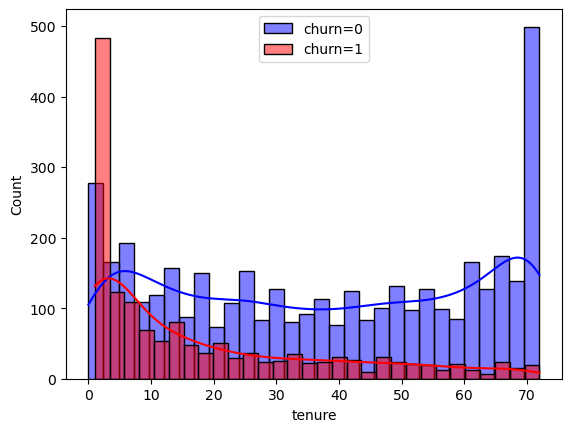

In [325]:
import seaborn as sns
df_full_train.groupby('tenure').churn.mean()

# in seaborn we can see by tenure the churn median in a graph
sns.histplot(df_full_train[df_full_train.churn == 0].tenure, color='blue', bins=30, kde=True, label='churn=0')
sns.histplot(df_full_train[df_full_train.churn == 1].tenure, color='red', bins=30, kde=True, label='churn=1')
plt.legend()



### One hot encoding for categorical variables

using scikit learn instead of doing it manually

In [326]:
from sklearn.feature_extraction import DictVectorizer # vectorizes dictionaries. is a transformer very smart as does not concert the numerical values

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict) # fit_transform is used to learn the transformation and then apply it to the data

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

### Logictic regression

using sigmoid to restrict the result to 0-1

1/(1+exp(-z))


In [327]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [328]:
z = np.linspace(-5, 5, 51)
z

array([-5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. ,
       -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8,
       -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,
        1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,
        3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ])

In [329]:
sigmoid(z)  

array([0.00669285, 0.00816257, 0.0099518 , 0.01212843, 0.01477403,
       0.01798621, 0.02188127, 0.02659699, 0.03229546, 0.03916572,
       0.04742587, 0.05732418, 0.06913842, 0.0831727 , 0.09975049,
       0.11920292, 0.14185106, 0.16798161, 0.19781611, 0.23147522,
       0.26894142, 0.31002552, 0.35434369, 0.40131234, 0.450166  ,
       0.5       , 0.549834  , 0.59868766, 0.64565631, 0.68997448,
       0.73105858, 0.76852478, 0.80218389, 0.83201839, 0.85814894,
       0.88079708, 0.90024951, 0.9168273 , 0.93086158, 0.94267582,
       0.95257413, 0.96083428, 0.96770454, 0.97340301, 0.97811873,
       0.98201379, 0.98522597, 0.98787157, 0.9900482 , 0.99183743,
       0.99330715])

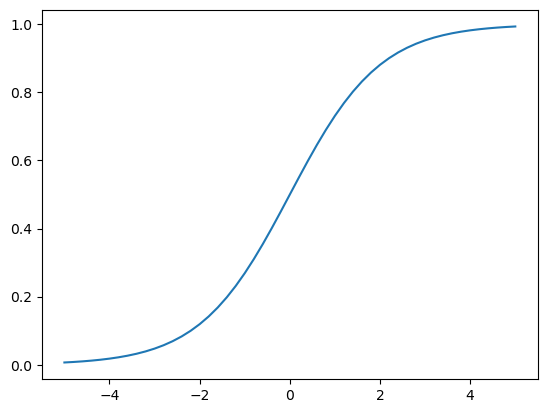

In [330]:
plt.plot(z, sigmoid(z))

In [331]:
def linear_regression(xi):
    result = w0
    
    for j in range(len(w)):
        result = result + xi[j] * w[j]
    
    return result

In [332]:
def logistic_regression(xi):
    score = w0
    
    for j in range(len(w)):
        score = score + xi[j] * w[j]
    
    result = sigmoid(score)
    return result

### training logistic regression with sklearn

In [333]:
from sklearn.linear_model import LogisticRegression


In [334]:
model = LogisticRegression()
model.fit(X_train, y_train)

/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [335]:
model.intercept_[0] # w0, the bias term

-0.10829812861544427

In [336]:
model.coef_[0].round(3) # this are the weights of the model

array([ 0.472, -0.171, -0.407, -0.031, -0.076,  0.062, -0.09 , -0.079,
       -0.034, -0.073, -0.33 ,  0.313, -0.09 ,  0.004, -0.255,  0.141,
        0.006,  0.062, -0.09 , -0.079,  0.261, -0.09 , -0.278, -0.227,
        0.12 , -0.164,  0.057, -0.086, -0.031,  0.066, -0.057,  0.141,
       -0.248,  0.212, -0.118, -0.09 ,  0.1  , -0.069, -0.09 ,  0.052,
        0.208, -0.09 , -0.226, -0.07 ,  0.   ])

In [337]:
model.predict(X_train) # this is the prediction of the model: we call them HARD PREDICTIONS as they are the actual predictions

array([0, 1, 1, ..., 1, 0, 1])

In [338]:
model.predict_proba(X_train) # this is the probability of the model: we call them SOFT PREDICTIONS as they are the probabilities. We see 2 columns as we have 2 classes


array([[0.90521264, 0.09478736],
       [0.3230037 , 0.6769963 ],
       [0.36735291, 0.63264709],
       ...,
       [0.4637139 , 0.5362861 ],
       [0.95685532, 0.04314468],
       [0.30382622, 0.69617378]])

In [339]:
# we are just interested in the second column as it is the probability of the positive class - churning
y_pred = model.predict_proba(X_val)[:, 1]

In [340]:
# and now we can make the hard predictions
churn_decision = (y_pred >= 0.5) # churn decision for example for promotional emails with discount

df_val[churn_decision].customerid

3       8433-wxgna
8       3440-jpscl
11      2637-fkfsy
12      7228-omtpn
19      6711-fldfb
           ...    
1397    5976-jcjrh
1398    2034-cgrhz
1399    5276-kqwhg
1407    6521-yytyi
1408    3049-solay
Name: customerid, Length: 313, dtype: object

How accurate are our predictions?

We can use accuracy

In [341]:
y_val == churn_decision

array([ True,  True,  True, ...,  True,  True,  True])

In [342]:
(y_val == churn_decision).mean()

0.8019872249822569

80% of predictions match

In [343]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred # soft predictions
df_pred['prediction'] = churn_decision.astype(int) # hard predictions
df_pred['actual'] = y_val # actual values

In [344]:
df_pred

,probability,prediction,actual
0,0.009377,0,0
1,0.206365,0,0
2,0.213500,0,0
3,0.544175,1,1
4,0.214825,0,0
...,...,...,...
1404,0.314914,0,0
1405,0.040401,0,1
1406,0.140165,0,0
1407,0.797574,1,1


In [345]:
df_pred['correct'] = df_pred.prediction == df_pred.actual
df_pred

,probability,prediction,actual,correct
0,0.009377,0,0,True
1,0.206365,0,0,True
2,0.213500,0,0,True
3,0.544175,1,1,True
4,0.214825,0,0,True
...,...,...,...,...
1404,0.314914,0,0,True
1405,0.040401,0,1,False
1406,0.140165,0,0,True
1407,0.797574,1,1,True


In [346]:
df_pred.correct.mean()

0.8019872249822569

### Model interpretation

looking at the coeficientsº

In [347]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

In [348]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3))) # zip put all the values together


{'contract=month-to-month': 0.472,
 'contract=one_year': -0.171,
 'contract=two_year': -0.407,
 'dependents=no': -0.031,
 'dependents=yes': -0.076,
 'deviceprotection=no': 0.062,
 'deviceprotection=no_internet_service': -0.09,
 'deviceprotection=yes': -0.079,
 'gender=female': -0.034,
 'gender=male': -0.073,
 'internetservice=dsl': -0.33,
 'internetservice=fiber_optic': 0.313,
 'internetservice=no': -0.09,
 'monthlycharges': 0.004,
 'multiplelines=no': -0.255,
 'multiplelines=no_phone_service': 0.141,
 'multiplelines=yes': 0.006,
 'onlinebackup=no': 0.062,
 'onlinebackup=no_internet_service': -0.09,
 'onlinebackup=yes': -0.079,
 'onlinesecurity=no': 0.261,
 'onlinesecurity=no_internet_service': -0.09,
 'onlinesecurity=yes': -0.278,
 'paperlessbilling=no': -0.227,
 'paperlessbilling=yes': 0.12,
 'partner=no': -0.164,
 'partner=yes': 0.057,
 'paymentmethod=bank_transfer_(automatic)': -0.086,
 'paymentmethod=credit_card_(automatic)': -0.031,
 'paymentmethod=electronic_check': 0.066,
 'pay

In [349]:
small = ['contract', 'tenure', 'monthlycharges']

In [350]:
df_train[small].iloc[:10].to_dict(orient='records')

[{'contract': 'two_year', 'tenure': 72, 'monthlycharges': 115.5},
 {'contract': 'month-to-month', 'tenure': 10, 'monthlycharges': 95.25},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 75.55},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 80.85},
 {'contract': 'two_year', 'tenure': 18, 'monthlycharges': 20.1},
 {'contract': 'month-to-month', 'tenure': 4, 'monthlycharges': 30.5},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 75.1},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 70.3},
 {'contract': 'two_year', 'tenure': 72, 'monthlycharges': 19.75},
 {'contract': 'month-to-month', 'tenure': 6, 'monthlycharges': 109.9}]

In [351]:
dicts_train_small = df_train[small].to_dict(orient='records')

In [352]:
dv_small = DictVectorizer(sparse=False)

### Using model

In [353]:
dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')

In [354]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [355]:
y_full_train = df_full_train.churn.values

In [356]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_full_train, y_full_train)

/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [357]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')

In [358]:
X_test = dv.transform(dicts_test)

In [359]:
y_pred = model.predict_proba(X_test)[:, 1]

In [360]:
churn_decision = (y_pred >= 0.5)

In [361]:
(churn_decision == y_test).mean()

0.8140525195173882

In [362]:
y_test

array([0, 0, 0, ..., 0, 0, 1])

In [363]:
customer = dicts_test[-1]
customer

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'no',
 'deviceprotection': 'yes',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 17,
 'monthlycharges': 104.2,
 'totalcharges': 1743.5}

In [ ]:
X_small = dv.transform([customer])

In [364]:
X_small = dv.transform([customer])
model.predict_proba(X_small)[0, 1]


0.656364161270536

In [365]:

y_test[-1]

1